In [145]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
from scipy import stats
import sys
sys.path.append("/global/homes/z/zhangtao/my_utils/src/")
from plot import contour
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import grangercausalitytests
import copy
from joblib import Parallel, delayed
from cmocean import cm as cmo
import statsmodels.api as sm
import metpy.calc as mpcalc
from statsmodels.tsa.vector_ar.var_model import VAR

from genutil import minmax
import cdutil
import cdms2 as cdms
import MV2 as MV
from statsmodels.tsa.tsatools import detrend

from tqdm.notebook  import tqdm
import multiprocessing as mp
from functools import partial
from loguru import logger
import importlib
from global_land_mask import globe
import cartopy.feature as cfeature
import cdtime
from matplotlib.colors import ListedColormap

In [14]:
lead_time = 0

lat_rgns = [-90, 90]
lon_rgns = [0, 360]

lat_rgns = [0,70]
lon_rgns = [180,300]

#lat_rgns = [-20, 20]
#lon_rgns = [240, 270]

lat = np.arange(-90,90,2)
lon = np.arange(0,360,2.5)

nlat = len(lat)
nlon = len(lon)


lon_fmt = np.zeros_like(lon)
for i in range(len(lon)):
    if lon[i] <= 180:
        lon_fmt[i] = lon[i]
    else:
        lon_fmt[i] = lon[i] - 360
        
lon_grid, lat_grid = np.meshgrid(lon_fmt,lat)
ocean_mask = globe.is_ocean(lat_grid, lon_grid)

grid = cdms.createGenericGrid(lat,lon)

methods = ["regression", "correlation", "granger","pc","lingam","ges","notears_linear"]
methods = ["regression","correlation", "notears_linear", "granger","pc","lingam"]

# functions

In [15]:
def calc_anorm(data):
    data_anorm = np.zeros_like(data)
    
    for i in range(12):
        data_climo = MV.average(data[i::12,:,:], axis=0)
        data_anorm[i::12,:,:] = data[i::12,:,:] - data_climo
        
    return data_anorm

In [16]:
def calc_anorm_stddata(data, data_cut):
    data_anorm = np.zeros_like(data)
    
    for i in range(12):
        data_climo = MV.average(data_cut[i::12,:,:], axis=0)
        data_anorm[i::12,:,:] = data[i::12,:,:] - data_climo
        
    return data_anorm

In [17]:
def calc_detrend(data):
    nlat = data.shape[1]
    nlon = data.shape[2]
    
    data_detrend = np.zeros_like(data)
    for i in range(nlat):
        for j in range(nlon):
            data_detrend[:,i,j] = detrend(data[:,i,j],order=2)
            
    return data_detrend

In [18]:
def expend_array(data, ntime,nlat,nlon):
    data_e = np.zeros([ntime,nlat,nlon])
    for i in range(nlat):
        for j in range(nlon):
            data_e[:,i,j] = data.reshape(-1)
            
    return data_e

In [19]:
def ENSO_cate():
    cate = np.zeros_like(ep)
    cate_len = cate.shape[0]

    for i in range(cate_len - 5):
        count1 = 0
        count2 = 0
        for j in range(i,i+5):
            if ep[j] >= 0.5:
                count1 += 1
            elif ep[j] <= -0.5:
                count2 += 1

        if count1 >= 5:
            cate[i:i+5] = 1
        elif count2 >= 5:
            cate[i:i+5] = -1

## causal_algs_parallel

In [126]:
from sklearn.linear_model import LinearRegression
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests
import os
os.environ['R_HOME'] = '/global/homes/z/zhangtao/.conda/envs/luffy/lib/R'
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
pcalg = importr('pcalg')

sys.path.append("/global/homes/z/zhangtao/climate_causal/notears/notears/")
import linear
import utils
import nonlinear
from sklearn import preprocessing

def calc_lag_corr(x,y,max_lag=1):
    if np.ma.is_masked(y) or np.ma.is_masked(x):
        corr = y[0] + x[0]
        return corr, corr
    else:
        max_corr = 0
        max_corr_p = 0
        ntime = len(x)
        for i in range(max_lag):
            corr, corr_p = stats.pearsonr(x[:ntime-i], y[i:])
            if abs(corr) > abs(max_corr):
                max_corr = corr
                max_corr_p = corr_p
        
        return max_corr, max_corr_p

def calc_corr(x,y):
    if np.ma.is_masked(y) or np.ma.is_masked(x):
        corr = y[0] + x[0]
        return corr, corr
    else:
        corr, corr_p = stats.pearsonr(x, y)
        
        return corr, corr_p

def calc_reg(x,y):
    if np.ma.is_masked(y) or np.ma.is_masked(x):
        reg = y[0] + x[0]
        return reg, reg
    else:
        X = sm.add_constant(x)
        #X = np.column_stack((x, x))
        reg_mod = sm.OLS(y,X).fit()
        reg = reg_mod.params[1]
        #reg = reg_mod.params[1]
        #reg_p = reg_mod.pvalues[0] + reg_mod.pvalues[0]
        reg_p = reg_mod.pvalues[1]
        return reg, reg_p
            
def calc_lingam(x,y):
    if np.ma.is_masked(y) or np.ma.is_masked(x):
        lingam = y[0] + x[0]
        return lingam,lingam
    else:
        data = np.transpose(np.array([x, y]))
        ro.globalenv['aa'] = data
        ro.r('res <- lingam(aa)')
        ro.r('resmat <- as(res, "amat")')
        resmat = np.array(ro.r['resmat'])
        lingam = resmat[0,1]
        return resmat[0,1], resmat[1,0]
    
def calc_pc(x,y):
    if np.ma.is_masked(y) or np.ma.is_masked(x):
        lingam = y[0] + x[0]
        return lingam,lingam
    else:
        data = np.transpose(np.array([x, y]))
        ro.globalenv['aa'] = data
        ro.r('suffStat <- list(C = cor(aa), n = nrow(aa))')
        ro.r('varname <- c("a","b")')
        ro.r('pc.fit = pc(suffStat, indepTest=gaussCItest, labels=varname, alpha=0.05)')
        ro.r('pcmat <- as(pc.fit@graph, "matrix")')
        pcmat = np.array(ro.r['pcmat'])
        #print(pcmat)
        return pcmat[0,1], pcmat[1,0]
    
def calc_granger(x,y):
    if np.ma.is_masked(y) or np.ma.is_masked(x):
        granger = y[0] + x[0]
        return granger, granger
    else:
        nlag = 7
        data = np.transpose(np.array([y, x]))
        granger_model = grangercausalitytests(data, nlag, verbose=False)
        granger = granger_model[1][0]['ssr_chi2test'][1]
        
        data = np.transpose(np.array([x, y]))
        granger_model = grangercausalitytests(data, nlag, verbose=False)
        granger_r = granger_model[1][0]['ssr_chi2test'][1]
                
        return granger, granger_r 

def causality_test(var1,var2):
    data1= pd.Series(var1, name='Var1')
    data2= pd.Series(var2, name='Var2')
    mdata=pd.concat([data1, data2], axis=1)
    #data = np.log(mdata).diff().dropna()
    data=mdata

    model = VAR(data)
    results=model.fit(7)
    #print(results.summary())

    foo=crit=results.test_causality('Var2', ['Var1'], kind='f')
    crit=foo.crit_value
    stat=foo.test_statistic
    if(stat > crit):
        cause=1
    else:
        cause=0

    return cause, cause
    
def calc_notears_block(x,y):
    block_x = y.shape[1]
    blocl_y = y.shape[2]
    
    notears = np.zeros_like(y[0,:,:])
    
    for i in range(block_x):
        for j in range(block_y):    
            if np.ma.is_masked(y) or np.ma.is_masked(x):
                notears = y[0,0,0] + x[0]
            else:
                data = np.transpose(np.array([x[:], y[:,i,j]]))         
                aa = linear.notears_linear(data, lambda1=0.1, loss_type='l2', max_iter=200)
                notears[i,j] = aa[0,1]

    return notears

def calc_notears(x,y):
    if np.ma.is_masked(y) or np.ma.is_masked(x):
        notears = y[0] + x[0]
        return notears, notears
    else:
        data = np.transpose(np.array([x, y]))         
        aa = linear.notears_linear(data, lambda1=0.1, loss_type='l2', max_iter=200, w_threshold=0.05)
        notears = aa[0,1]
        return aa[0,1], aa[1,0]

def calc_corr_wrapper(args):
    #return calc_corr(*args)
    return calc_lag_corr(*args)

def calc_reg_wrapper(args):
    return calc_reg(*args)

def calc_notears_wrapper(args):
    return calc_notears(*args)

def calc_lingam_wrapper(args):
    return calc_lingam(*args)

def calc_pc_wrapper(args):
    return calc_pc(*args)

def calc_granger_wrapper(args):
    return calc_granger(*args)
    #return causality_test(*args)


## causal_algs_2d_to_2d

In [113]:
def causal_algs_2d_to_2d(data,nlat,nlon):
    results={}

    pool = mp.Pool(10)
    logger.info("Calc correlation")
    r = pool.map(calc_corr_wrapper,data)
    a = np.ma.masked_array([c[0] for c in r]).reshape(nlat,nlon)
    p = np.ma.masked_array([c[1] for c in r]).reshape(nlat,nlon)
    results['correlation'] = a
    results['correlation_p'] = p
    
#     logger.info("Calc regression")
#     r = pool.map(calc_reg_wrapper,data)
#     a = np.ma.masked_array([c[0] for c in r]).reshape(nlat,nlon)
#     p = np.ma.masked_array([c[1] for c in r]).reshape(nlat,nlon)
#     results['reg'] = a
#     results['reg_p'] = p

    logger.info("Calc notears linear")
    r = pool.map(calc_notears_wrapper,data)
    a = np.ma.masked_array([c[0] for c in r]).reshape(nlat,nlon)
    b = np.ma.masked_array([c[1] for c in r]).reshape(nlat,nlon)
    results['notears_linear'] = a
    results['notears_linear_r'] = b 

    logger.info("Calc lingam")
    r = pool.map(calc_lingam_wrapper,data)
    a = np.ma.masked_array([c[0] for c in r]).reshape(nlat,nlon)
    b = np.ma.masked_array([c[1] for c in r]).reshape(nlat,nlon)
    results['lingam'] = a
    results['lingam_r'] = b
    
    logger.info("Calc Granger")
    r = pool.map(calc_granger_wrapper,data)
    a = np.ma.masked_array([c[0] for c in r]).reshape(nlat,nlon)
    b = np.ma.masked_array([c[1] for c in r]).reshape(nlat,nlon)
    results['granger'] = a
    results['granger_r'] = b
    
    logger.info("Calc pc")
    r = pool.map(calc_pc_wrapper,data)
    a = np.ma.masked_array([c[0] for c in r]).reshape(nlat,nlon)
    b = np.ma.masked_array([c[1] for c in r]).reshape(nlat,nlon)
    results['pc'] = a
    results['pc_r'] = b
        
    return results

## calc_API

In [26]:
def calc_API(pr):
    '''
    the tropical precipitation asymmetry index precipitation 
    difference between the northern [0 – 20N] and southern tropics 
    [20S – 0] normalized by the tropical mean [20°S – 20°N]
    '''
    
    lat = pr.getLatitude()[:]
    lon = pr.getLongitude()[:]
    
    pr_N, lat_N, lon_N = slice_region(pr, lat, lon, [0,20], [0,360])
    pr_S, lat_S, lon_S = slice_region(pr, lat, lon, [-20,0], [0,360])
    pr_NS,lat_NS, lon_NS = slice_region(pr, lat, lon, [-20,20], [0,360])

    pr_N_mm = cdutil.averager(cdms.asVariable(pr_N),axis='xy',weights='weighted')
    pr_S_mm = cdutil.averager(cdms.asVariable(pr_S),axis='xy',weights='weighted')
    pr_NS_mm = cdutil.averager(cdms.asVariable(pr_NS),axis='xy',weights='weighted')

    API = (pr_N_mm - pr_S_mm)/pr_NS_mm
    
    return API

## generate_lead_data

In [27]:
def generate_lead_data(a, b, lag_time):
    '''
    a is a 1d array; b is a 2d array;
    a is lag, b is lead
    '''
    nrows = a.shape[0]
    
    row_deleted = np.arange(nrows-1-lag_time,nrows-1)
    a_lag = a[lag_time:]
    b_lag = b[:nrows-lag_time]
        
    return a_lag, b_lag

## generate_lag_data

In [28]:
'''
a is a 1d array; b is a 2d array;
a is lead, b is lag
'''
def generate_lag_data(a, b, lag_time):
    nrows = a.shape[0]
    
    row_deleted = np.arange(nrows-1-lag_time,nrows-1)
    a_lag = np.delete(a, row_deleted, 0)
    
    b_lag = b[lag_time:,:,:]
    
    print(a_lag.shape)
    
    return a_lag, b_lag

## slice_region

In [29]:
def slice_region(var, lat, lon, sublat, sublon):
    '''
    get partial region of the global variable
    '''
    
    sublat_ind = np.where((lat >= sublat[0]) & (lat <= sublat[1]))
    sublon_ind = np.where((lon >= sublon[0]) & (lon <= sublon[1]))
    
    if len(var.shape) == 3:
        return var[:,sublat_ind[0][0]:sublat_ind[0][-1]+1, sublon_ind[0][0]:sublon_ind[0][-1]+1], lat[sublat_ind], lon[sublon_ind]
    if len(var.shape) == 2:
        return var[sublat_ind[0][0]:sublat_ind[0][-1]+1, sublon_ind[0][0]:sublon_ind[0][-1]+1], lat[sublat_ind], lon[sublon_ind]

In [30]:
def plot_causal_method(result,title,reg_c,nol_c,lat,lon, lat_rgns, lon_rgns, mask=True):
    fig, axes = plt.subplots(2,1,figsize=(7,5), subplot_kw={'projection': ccrs.PlateCarree(180)}, squeeze=False)
    
    if mask == True:
        contour.plot_2d_contourf_by_array_region(fig, axes[0][0], np.ma.masked_array(result['reg'],mask=ocean_mask), 
                              lat, lon, lat_rgns, lon_rgns, 'Regression', '', nol_c)
        contour.plot_corrsig_only(axes[0][0], np.ma.masked_array(result["reg_p"], mask=ocean_mask).filled(fill_value=np.nan), 
                              lat, lon, lat_rgns, lon_rgns, 0.05)
        
        contour.plot_2d_contourf_by_array_region(fig, axes[1][0], np.ma.masked_array(result['notears_linear'],mask=ocean_mask), 
                                             lat, lon, lat_rgns, lon_rgns, "Notears_linear/Granger", '', nol_c)
        contour.plot_corrsig_only(axes[0][0], np.ma.masked_array(result["granger"], mask=ocean_mask).filled(fill_value=np.nan), 
                                              lat, lon, lat_rgns, lon_rgns, 0.05)       
        
    if mask == False:
        contour.plot_2d_contourf_by_array_region(fig, axes[0][0], result['reg'], 
                                                 lat, lon, lat_rgns, lon_rgns, 'Regression', '', reg_c)
        contour.plot_corrsig_only(axes[0][0], result["reg_p"], lat, lon, lat_rgns, lon_rgns, 0.05)
  
        contour.plot_2d_contourf_by_array_region(fig, axes[1][0], result['notears_linear'], 
                                                 lat, lon, lat_rgns, lon_rgns, "Notears_linear/Granger", '', nol_c)
        contour.plot_corrsig_only(axes[1][0], result["granger"], lat, lon, lat_rgns, lon_rgns, 0.05)
       
    
    fig.suptitle(title,fontsize=18)
    
    plt.tight_layout()

In [31]:
def plot_causal_overlap(result,title,reg_c,nol_c,lat,lon, lat_rgns, lon_rgns, mask=True):
    fig, axes = plt.subplots(2,1,figsize=(7,8), subplot_kw={'projection': ccrs.PlateCarree(180)}, squeeze=False)
    
#     contour.plot_2d_contourf_by_array_region(fig, axes[0][0], np.ma.masked_array(result['TAS']['reg'],mask=ocean_mask), 
#                               lat, lon, lat_rgns, lon_rgns, 'Regression', '', nol_c)
#     contour.plot_corrsig_only(axes[0][0], np.ma.masked_array(result['TAS']["reg_p"], mask=ocean_mask).filled(fill_value=np.nan), 
#                               lat, lon, lat_rgns, lon_rgns, 0.05)
#     contour.plot_2d_contour_by_array_region(fig, axes[0][0], result['HGT']['reg'], 
#                               lat, lon, lat_rgns, lon_rgns, 'Regression')
        
    #contour.plot_2d_contourf_by_array_region(fig, axes[0][0], np.ma.masked_array(result['TAS']['notears_linear'],mask=ocean_mask), 
    #                          lat, lon, lat_rgns, lon_rgns, 'Notears_linear/Granger', '', nol_c)
    contour.plot_2d_contourf_by_array_region(fig, axes[0][0], result['TAS']['notears_linear'], 
                              lat, lon, lat_rgns, lon_rgns, 'Notears_linear', '', nol_c)    
    
    contour.plot_corrsig_only(axes[1][0], np.ma.masked_array(result['TAS']["granger"], mask=ocean_mask).filled(fill_value=np.nan), 
                              lat, lon, lat_rgns, lon_rgns, 0.05)
    contour.plot_2d_contour_by_array_region(fig, axes[0][0], result['HGT']['notears_linear'], 
                              lat, lon, lat_rgns, lon_rgns, 'Notears_linear')
    
    #fig.suptitle(title,fontsize=18)
    
    plt.tight_layout()

## get_season

In [32]:
def get_season(var,season):
    ntime = var.shape[0]
    nys = ntime // 12
    #var_slice = copy.deepcopy(var)
    
    if season=="FY": # first half year
        #var_slice = np.zeros([ntime//2, nlat, nlon])
        var_slice = var_slice[:ntime//2,:,:]
        
        for yr in range(nys):
            var_slice[yr*6:(yr+1)*6,:,:] = var[yr*12:yr*12+6,:,:]
            
        return var_slice
    
    elif season=='winter':
        
        if var.ndim == 2:
            var_slice = np.zeros([ntime//4,1])
        elif var.ndim == 3:
            var_slice = np.zeros([ntime//4,var.shape[1],var.shape[2]])
        
        for i in range(ntime//4):
            if i % 3 == 0:
                offset = 0
            elif i % 3 == 1:
                offset = 1
            elif i % 3 == 2:
                offset = 11
             
            #print((i//3)*12+offset)
            if var.ndim == 1:
                var_slice[i,0] = var[(i//3)*12+offset,0]
            elif var.ndim == 3:
                var_slice[i,:,:] = var[(i//3)*12+offset,:,:]
        
        return var_slice

# load index data

In [33]:
index_list = ["ENSO","EP","CP"]
#index_list = ["EP","CP"]
index_path_list = ['ONI/oni_category_cut.csv',
                   'ONI/EP_category_cut.csv',
                   'ONI/CP_category_cut.csv'
                   ]
index_var = [
    "ANOM",
    "EP",
    "CP"
]

## El Nino index

In [34]:
nino_index = {}
nino_index_idx = {}

composite = False

for i,var in enumerate(index_list):
    logger.info("Reading index of "+var)
    #logger.debug(index_path_list[i])
    
    index_pd = pd.read_csv(index_path_list[i])
    index = np.array(index_pd.loc[:,index_var[i]]).reshape(-1,1)
    
    index_3d = expend_array(index,index.shape[0],nlat,nlon)
    
    if composite == True:
        idx = np.array(index_pd[((index_pd['Month'] <=3) | (index_pd['Month'] >=11)) & (index_pd['category'] == 1)].index.values)
        logger.info("Shape of "+var+" is: "+ str(len(idx)))

        nino_index_idx[var] = idx
        nino_index[var] = np.transpose(index_3d[idx,:,:].reshape(-1,nlat*nlon))
        #nino_index[var] = index_3d[idx,:,:]
    else:
        print(var)
        nino_index[var] = np.transpose(index_3d[:-12,:,:].reshape(-1,nlat*nlon))
        
    logger.info("Shape of "+var+" is: "+ str(nino_index[var].shape[1]))

2020-12-27 15:20:30.450 | INFO     | __main__:<module>:7 - Reading index of ENSO
2020-12-27 15:20:30.551 | INFO     | __main__:<module>:26 - Shape of ENSO is: 792
2020-12-27 15:20:30.552 | INFO     | __main__:<module>:7 - Reading index of EP
2020-12-27 15:20:30.648 | INFO     | __main__:<module>:26 - Shape of EP is: 792
2020-12-27 15:20:30.649 | INFO     | __main__:<module>:7 - Reading index of CP
2020-12-27 15:20:30.750 | INFO     | __main__:<module>:26 - Shape of CP is: 792


ENSO
EP
CP


In [35]:
print(nino_index['ENSO'].shape)
print(nino_index['CP'].shape)
print(nino_index['EP'].shape)

(12960, 792)
(12960, 792)
(12960, 792)


# load var data

In [36]:
var_list = ['TAS']
path_obs_list = [#"/D1/tao/bigdata/double-itcz/obs/time_series/skt.mon.mean.nc"
                 "/global/homes/z/zhangtao/climate_causal/ENSO/data/ncar_ncep_ts_194801_202010.nc"
]
var_obs_names = [#"skt"
                "air"
]

path_climo_list = [
    "/D1/tao/bigdata/double-itcz/obs/climo/ncar/obs_for_diagnostics/NCEP_climo.nc",
    "/D1/tao/bigdata/double-itcz/obs/climo/ncar/obs_for_diagnostics/NCEP_climo.nc"
]

var_climo_names = [
    "TS",
    "Z3"
]

In [37]:
var_obs_nino = {}
composite=False

t1 = cdtime.comptime(1950,1,1)
t2 = cdtime.comptime(2015,12,31)

for i,var in enumerate(var_list):
    logger.info("Reading obs of "+var)
    logger.debug(path_obs_list[i],var_obs_names[i])
    
    f1_obs = cdms.open(path_obs_list[i])
    
    if var == 'TAS':
        var_obs = f1_obs(var_obs_names[i]).subRegion(time=(t1,t2))

        
    lat = var_obs.getLatitude()[:]
    lon = var_obs.getLongitude()[:]
    nlat = len(lat)
    nlon = len(lon)
    print(nlat)
    print(nlon)
    
    logger.info("Shape of "+var+" is: "+ str(var_obs.shape[0]))
    
    #var_obs_remap = var_obs.regrid(grid,regridTool='esmf',regridMethod='linear')
    var_obs_remap = calc_detrend(var_obs)
    print(var_obs_remap.shape)
    
    var_obs_anorm = np.array(calc_anorm_stddata(var_obs_remap, var_obs_remap))
    print(var_obs_anorm.shape)
    
    if composite == True:
        #var_obs_nino[var] = np.transpose(var_obs_anorm[nino_index_idx[ENSO_id],:,:].reshape(-1,nlat*nlon))
        var_obs_nino[var] = var_obs_anorm[nino_index_idx[ENSO_id],:,:]
    else:
        var_obs_nino[var] = np.transpose(var_obs_anorm.reshape(-1,nlat*nlon))
    
    

2020-12-27 15:24:18.279 | INFO     | __main__:<module>:8 - Reading obs of TAS
2020-12-27 15:24:18.280 | DEBUG    | __main__:<module>:9 - /global/homes/z/zhangtao/climate_causal/ENSO/data/ncar_ncep_ts_194801_202010.nc
2020-12-27 15:24:18.797 | INFO     | __main__:<module>:24 - Shape of TAS is: 792


73
144
(792, 73, 144)
(792, 73, 144)


# ENSO causal 

In [127]:
causal_result = {}
index_list=['ENSO']
for index in index_list:
    print("doing "+index)
    combine_list = list(zip(nino_index[index],var_obs_nino["TAS"]))
    #combine_list = list(zip(var_obs_nino[var],nino_index[ENSO_id]))
    causal_result[index] = causal_algs_2d_to_2d(combine_list, nlat,nlon)
    
    #print(minmax(causal_result[index]['reg']))
    #print(minmax(causal_result[var]['notears_linear']))
    #print(minmax(causal_result[var]['notears_linear_r']))

doing ENSO


2020-12-28 19:10:52.100 | INFO     | __main__:causal_algs_2d_to_2d:5 - Calc correlation
2020-12-28 19:10:52.821 | INFO     | __main__:causal_algs_2d_to_2d:19 - Calc notears linear
2020-12-28 19:11:09.053 | INFO     | __main__:causal_algs_2d_to_2d:26 - Calc lingam
2020-12-28 19:11:37.895 | INFO     | __main__:causal_algs_2d_to_2d:33 - Calc Granger
2020-12-28 19:12:55.721 | INFO     | __main__:causal_algs_2d_to_2d:40 - Calc pc


In [128]:
lon_fmt = np.zeros_like(lon)
for i in range(len(lon)):
    if lon[i] <= 180:
        lon_fmt[i] = lon[i]
    else:
        lon_fmt[i] = lon[i] - 360
lon_grid, lat_grid = np.meshgrid(lon_fmt,lat)
ocean_mask = globe.is_ocean(lat_grid, lon_grid)

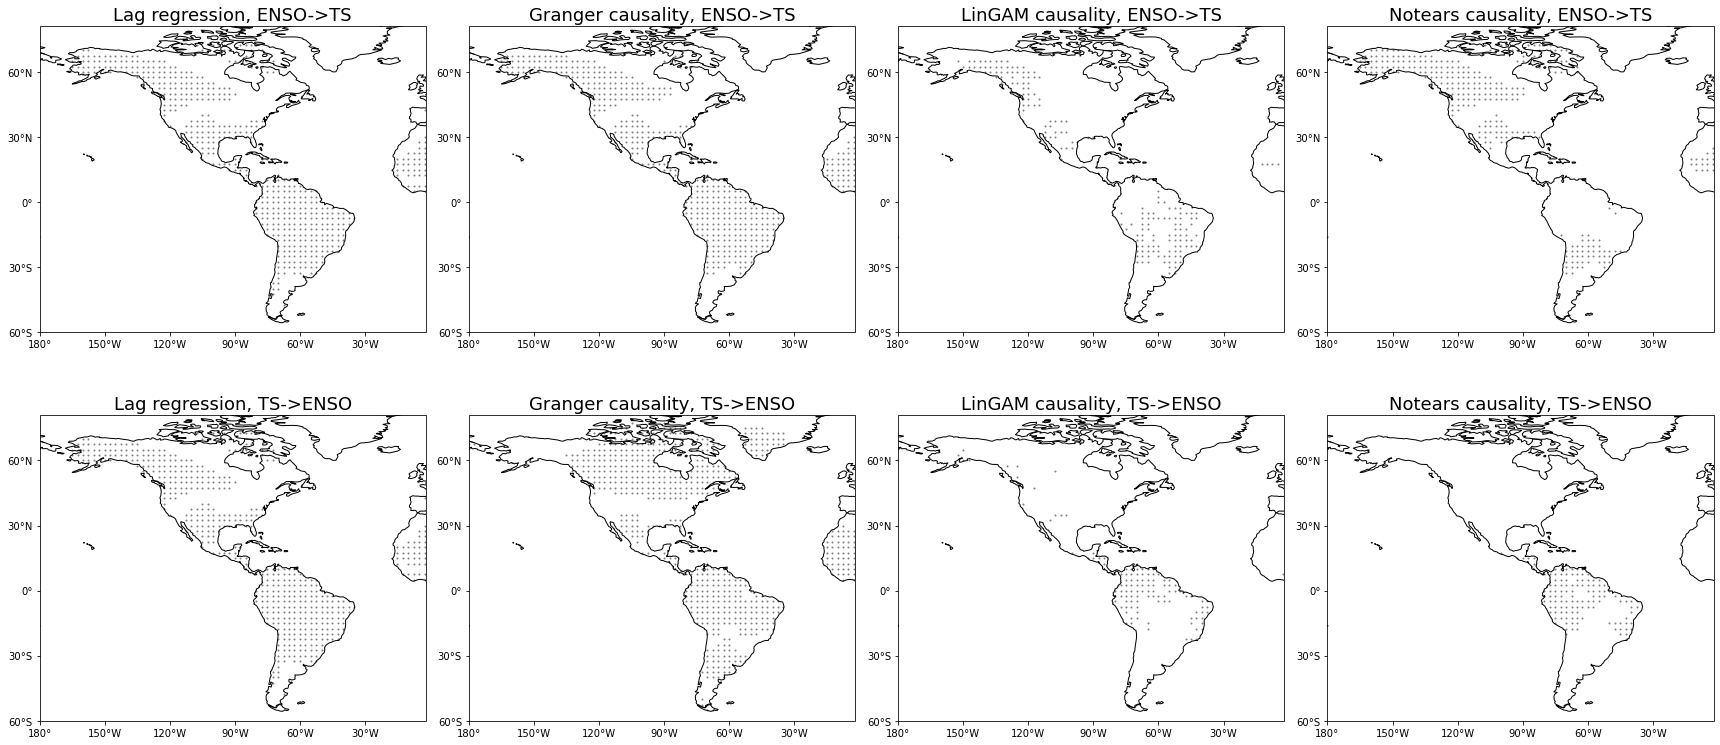

In [129]:
importlib.reload(contour)
fig, axes = plt.subplots(2,4,figsize=(6*4,5.5*2), subplot_kw={'projection': ccrs.PlateCarree(180)}, squeeze=False)

# lagged correlation
causal_result['ENSO']['correlation_p'][ocean_mask] = 1
idx = np.where(causal_result['ENSO']['correlation_p'] <= 0.05)
slat = lat[idx[0]]
slon = lon[idx[1]]
ax = contour.plot_scatter(axes[0][0], lat_rgns, lon_rgns, slat, slon, "Lag regression, ENSO->TS")

# granger
causal_result['ENSO']['granger'][ocean_mask] = 1
idx = np.where(causal_result['ENSO']['granger'] <= 0.05)
slat = lat[idx[0]]
slon = lon[idx[1]]
ax = contour.plot_scatter(axes[0][1], lat_rgns, lon_rgns, slat, slon, "Granger causality, ENSO->TS")

# lingam
causal_result['ENSO']['lingam'][ocean_mask] = 0
idx = np.where(causal_result['ENSO']['lingam'] == 1)
slat = lat[idx[0]]
slon = lon[idx[1]]
ax = contour.plot_scatter(axes[0][2], lat_rgns, lon_rgns, slat, slon, "LinGAM causality, ENSO->TS")

# Notears
causal_result['ENSO']['notears_linear'][ocean_mask] = 0
idx = np.where(causal_result['ENSO']['notears_linear'] != 0)
slat = lat[idx[0]]
slon = lon[idx[1]]
ax = contour.plot_scatter(axes[0][3], lat_rgns, lon_rgns, slat, slon, "Notears causality, ENSO->TS")


# lagged correlation
causal_result['ENSO']['correlation_p'][ocean_mask] = 1
idx = np.where(causal_result['ENSO']['correlation_p'] <= 0.05)
slat = lat[idx[0]]
slon = lon[idx[1]]
ax = contour.plot_scatter(axes[1][0], lat_rgns, lon_rgns, slat, slon, "Lag regression, TS->ENSO")

# granger
causal_result['ENSO']['granger_r'][ocean_mask] = 1
idx = np.where(causal_result['ENSO']['granger_r'] <= 0.05)
slat = lat[idx[0]]
slon = lon[idx[1]]
ax = contour.plot_scatter(axes[1][1], lat_rgns, lon_rgns, slat, slon, "Granger causality, TS->ENSO")

# lingam
causal_result['ENSO']['lingam_r'][ocean_mask] = 0
idx = np.where(causal_result['ENSO']['lingam_r'] == 1)
slat = lat[idx[0]]
slon = lon[idx[1]]
ax = contour.plot_scatter(axes[1][2], lat_rgns, lon_rgns, slat, slon, "LinGAM causality, TS->ENSO")

# Notears
causal_result['ENSO']['notears_linear_r'][ocean_mask] = 0
idx = np.where(causal_result['ENSO']['notears_linear_r'] != 0)
slat = lat[idx[0]]
slon = lon[idx[1]]
ax = contour.plot_scatter(axes[1][3], lat_rgns, lon_rgns, slat, slon, "Notears causality, TS->ENSO")

plt.tight_layout()

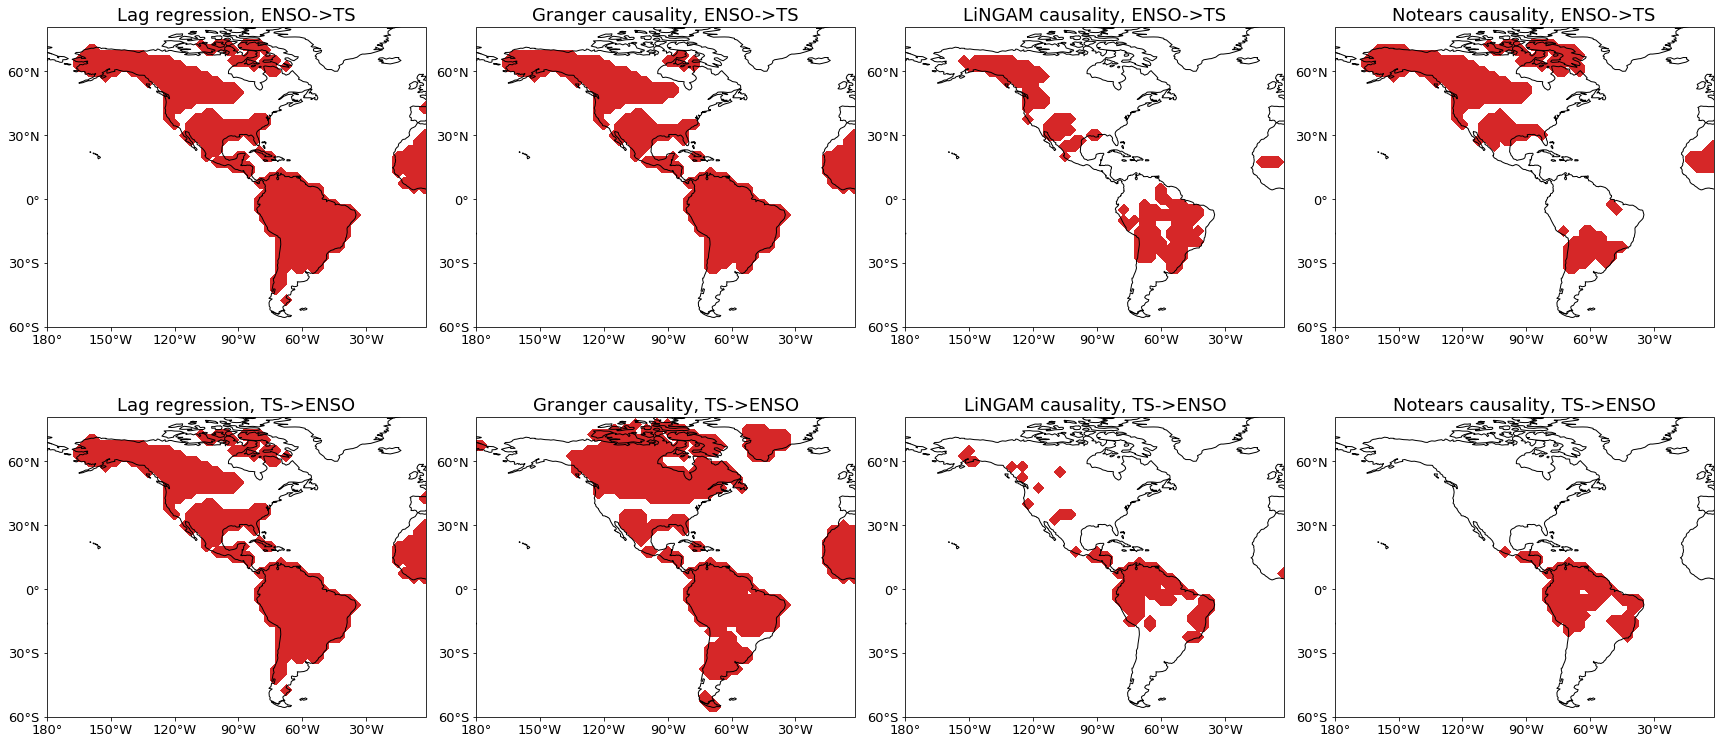

In [159]:
importlib.reload(contour)
fig, axes = plt.subplots(2,4,figsize=(6*4,5.5*2), subplot_kw={'projection': ccrs.PlateCarree(180)}, squeeze=False)

# lagged correlation
aa = np.where(causal_result['ENSO']['correlation_p'] <= 0.05, 1, 0)
aa[ocean_mask] = 0
ax = contour.plot_2d_contourf_PlateCarree(fig, axes[0][0], aa, lat, lon, lat_rgns, lon_rgns,
                                          'Lag regression, ENSO->TS','',[0,1],cmap=ListedColormap(['white','tab:red']))

# granger
aa = np.where(causal_result['ENSO']['granger'] <= 0.05, 1, 0)
aa[ocean_mask] = 0
ax = contour.plot_2d_contourf_PlateCarree(fig, axes[0][1], aa, lat, lon, lat_rgns, lon_rgns,
                                          'Granger causality, ENSO->TS','',[0,1],cmap=ListedColormap(['white','tab:red']))

# lingam
aa = np.where(causal_result['ENSO']['lingam'] == 1,1,0)
aa[ocean_mask] = 0
ax = contour.plot_2d_contourf_PlateCarree(fig, axes[0][2], aa, lat, lon, lat_rgns, lon_rgns,
                                          'LiNGAM causality, ENSO->TS','',[0,1],cmap=ListedColormap(['white','tab:red']))

# Notears
aa = np.where(causal_result['ENSO']['notears_linear'] != 0, 1, 0)
aa[ocean_mask] = 0
ax = contour.plot_2d_contourf_PlateCarree(fig, axes[0][3], aa, lat, lon, lat_rgns, lon_rgns,
                                          'Notears causality, ENSO->TS','',[0,1],cmap=ListedColormap(['white','tab:red']))

# lagged correlation
aa = np.where(causal_result['ENSO']['correlation_p'] <= 0.05, 1, 0)
aa[ocean_mask] = 0
ax = contour.plot_2d_contourf_PlateCarree(fig, axes[1][0], aa, lat, lon, lat_rgns, lon_rgns,
                                          'Lag regression, TS->ENSO','',[0,1],cmap=ListedColormap(['white','tab:red']))

# granger
aa = np.where(causal_result['ENSO']['granger_r'] <= 0.05, 1, 0)
aa[ocean_mask] = 0
ax = contour.plot_2d_contourf_PlateCarree(fig, axes[1][1], aa, lat, lon, lat_rgns, lon_rgns,
                                          'Granger causality, TS->ENSO','',[0,1],cmap=ListedColormap(['white','tab:red']))

# lingam
aa = np.where(causal_result['ENSO']['lingam_r'] == 1,1,0)
aa[ocean_mask] = 0
ax = contour.plot_2d_contourf_PlateCarree(fig, axes[1][2], aa, lat, lon, lat_rgns, lon_rgns,
                                          'LiNGAM causality, TS->ENSO','',[0,1],cmap=ListedColormap(['white','tab:red']))

# Notears
aa = np.where(causal_result['ENSO']['notears_linear_r'] != 0, 1, 0)
aa[ocean_mask] = 0
ax = contour.plot_2d_contourf_PlateCarree(fig, axes[1][3], aa, lat, lon, lat_rgns, lon_rgns,
                                          'Notears causality, TS->ENSO','',[0,1],cmap=ListedColormap(['white','tab:red']))

plt.tight_layout()

In [175]:
varns = ["T"]
varns_diff = ["TDIFF"]

fid = cdms.open("~/tmp/camrun.cam.h1.0095-07-19-00000.nc")

for i,varn in enumerate(varns):
    print(varn)
    
    var = fid(varn)[:,:,0,0]
    diff = fid(varns_diff[i])[:,:,0,0]
    forcing = var - diff

    #print(var.shape, forcing.shape)
    
    for j in range(30):    
        causal = forcing[:-1,-1]
        effect = var[1:,j]

        #print("corr: ",str(j),calc_corr(causal,effect))
        print("notears: ",str(j),calc_notears(causal,effect))
        #print("lingam: ",str(j),calc_lingam(causal,effect))
        #print("granger1: ",str(j),calc_granger(causal,effect))
        #print("granger2: ",str(j),calc_granger(effect,causal))    


T
notears:  0 (0.0, 0.4198754534490985)
notears:  1 (0.0, 1.0304973504471515)
notears:  2 (0.0, 6.640133286048046)
notears:  3 (0.0, 3.285893800558712)
notears:  4 (0.0, 5.146228839610279)
notears:  5 (0.0, 0.6762666400324132)
notears:  6 (0.0, 0.7465169569263171)
notears:  7 (0.0, 2.000053217131211)
notears:  8 (0.0, 1.7662644216813699)
notears:  9 (0.0, 0.3600582539466923)
notears:  10 (0.0, 0.0)
notears:  11 (0.0, 0.0)
notears:  12 (0.0, 0.0)
notears:  13 (0.0, 0.594667116886629)
notears:  14 (0.0, 0.0)
notears:  15 (0.0, 0.0)
notears:  16 (0.0, 0.0)
notears:  17 (0.0, 0.0)
notears:  18 (0.0, 0.64510407497191)
notears:  19 (0.0, 0.9269287158201776)
notears:  20 (0.0, 0.8001899926130842)
notears:  21 (0.0, 0.5525433281697044)
notears:  22 (0.0, 0.43612243605400786)
notears:  23 (0.0, 0.4329776044442399)
notears:  24 (0.0, 0.46619471149635244)
notears:  25 (0.0, 0.6286631137813496)
notears:  26 (0.0, 0.8359478422090445)
notears:  27 (0.0, 1.0690826727174743)
notears:  28 (0.0, 1.03336

In [201]:
T = fid("T")[:,:,0,0]
q = fid("Q")[:,:,0,0]
TDIFF = fid("TDIFF")[:,:,0,0]
TS = fid("TS")[:,0,0]
print(T.shape)

T_forcing = T - TDIFF
print(T_forcing[:,-1].shape)

(1009, 30)
(1009,)


In [161]:
causal = T_forcing[:-1,-1]
#effect = TS[100:]
effect = T[1:,-1]
print("notears: ",calc_notears(causal,effect))
print("lingam: ",calc_lingam(causal,effect))

notears:  (0.0, 1.0558365693365355)
lingam:  (1, 0)


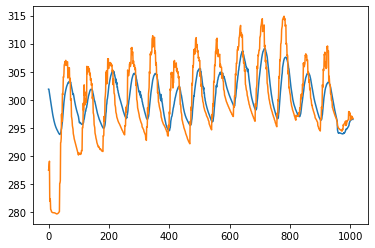

In [139]:
plt.plot(np.array(T[:,-1]))
plt.plot(np.array(TS))

In [199]:
fid1 = cdms.open("~/tmp/ARM95_4scam.nc")
T_f = fid1('T')[55:55+1009,:,0,0]
Tg_f = fid1('Tg')[55:55+1009,0,0]
print(T_f.shape)

(1009, 18)


In [209]:
causal = T_f[:,-4]
causal = Tg_f
effect = TS
print("notears: ",calc_notears(np.array(causal), np.array(effect)))

notears:  (1.8858502441130127, 0.0)


In [203]:
fid1 = cdms.open("~/tmp/ARM95_4scam.nc")
q_f = fid1('q')[55:55+1009,:,0,0]
print(q_f.shape)

(1009, 18)


In [208]:
causal = q_f[:,-3]
effect = q[:,-1]
print("notears: ",calc_notears(np.array(causal), np.array(effect)))
print("notears: ",calc_corr(np.array(causal), np.array(effect)))

notears:  (0.0, 0.0)
notears:  (-0.009530716019584504, 0.7623681061714108)


In [110]:
data = np.random.rand(100,2)
x = data[:,0]
y = 4*x + data[:,1]

print(calc_pc(x,y))

[[0. 1.]
 [1. 0.]]
(1.0, 1.0)
